In [1]:
import scvelo as scv
import scanpy as spy
import numpy as np  
from sklearn.decomposition import PCA, IncrementalPCA
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.axes._axes import _log as matplotlib_axes_logger

import seaborn as sns

matplotlib_axes_logger.setLevel('ERROR')
import json
import anndata

import cellpath.CellPath as CP
import cellpath.visual as visual
import cellpath.benchmark as bmk 


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

# CellPath

In [2]:
# read in simulated dataset
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1_clust.h5ad")
# adata = anndata.read_h5ad("./sim_data/Dyngen/Trifurcating_clust.h5ad")

## Step by step CellPath

In [3]:
# cellpath_obj = CP.CellPath(adata = adata)
# # self, n_clusters = None, include_unspliced = True, standardize = True, **kwarg
# cellpath_obj.meta_cell_construction(n_clusters=300, include_unspliced = True, standardize = True)
# cellpath_obj.meta_cell_graph(k_neighs = 10)
# cellpath_obj.meta_paths_finding(threshold = 0.5, cutoff_length = 5, length_bias = 0.7)
# cellpath_obj.first_order_pt(num_trajs = None)

## All in one CellPath

In [4]:
cellpath_obj = CP.CellPath(adata = adata)
cellpath_obj.all_in_one(num_metacells = 400, n_neighs = 10)

Already conducted clustering
Meta-cell constructed
Meta-cell level neighborhood graph constructed
cut off small paths and conduct quality control
selected path (starting_ending):
start_end:  116_272 , len:  54 newly covered: 54
start_end:  116_21 , len:  51 newly covered: 19
start_end:  116_57 , len:  54 newly covered: 10
start_end:  116_65 , len:  51 newly covered: 9
start_end:  116_46 , len:  53 newly covered: 3
start_end:  116_323 , len:  53 newly covered: 3
start_end:  116_92 , len:  50 newly covered: 5
start_end:  116_395 , len:  54 newly covered: 2
start_end:  116_126 , len:  54 newly covered: 2
start_end:  116_359 , len:  53 newly covered: 2
start_end:  116_23 , len:  54 newly covered: 1
start_end:  116_75 , len:  54 newly covered: 1
start_end:  116_131 , len:  54 newly covered: 1
start_end:  116_154 , len:  54 newly covered: 1
start_end:  116_290 , len:  54 newly covered: 1
start_end:  116_333 , len:  54 newly covered: 1
start_end:  116_340 , len:  54 newly covered: 1
start_end

## Visualization

The clusters with radius close to 0 has components number:
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

96

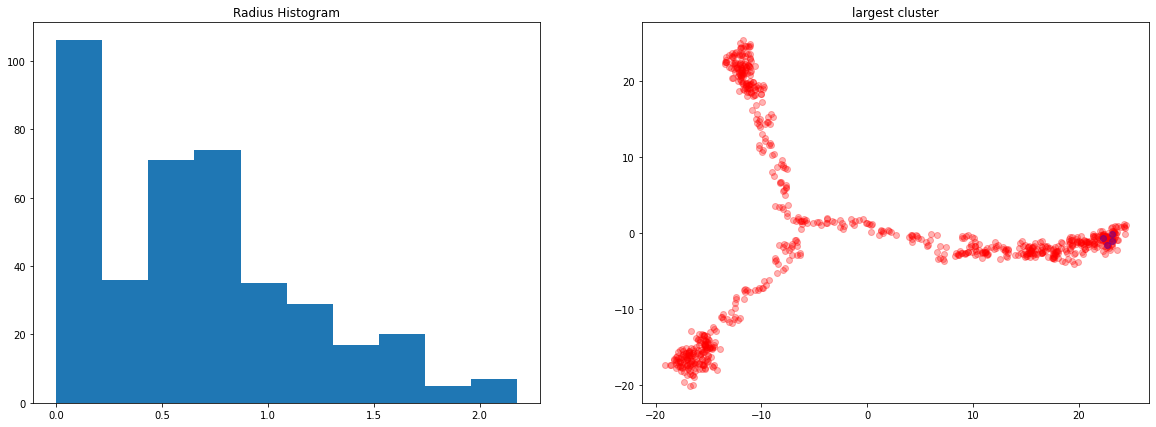

In [13]:
visual.radius_hist(cellpath_obj, resolution=10)

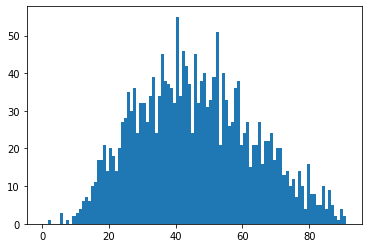

In [5]:
visual.weight_histogram(cellpath_obj, resolution = 100)

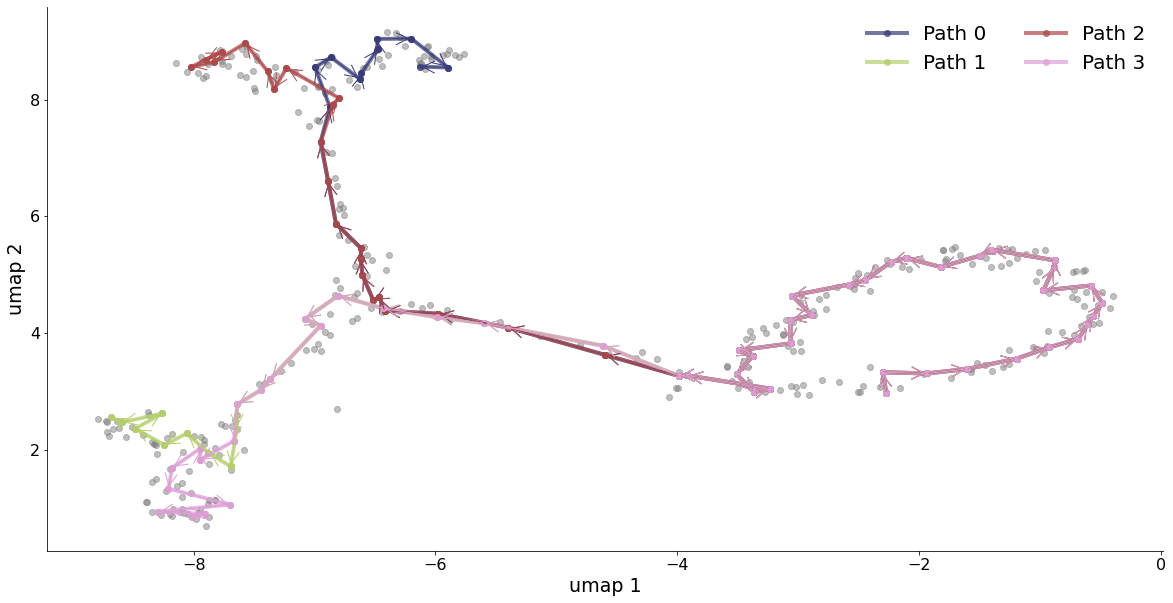

In [6]:
visual.meta_traj_visual(cellpath_obj, basis="umap", trajs = 4)

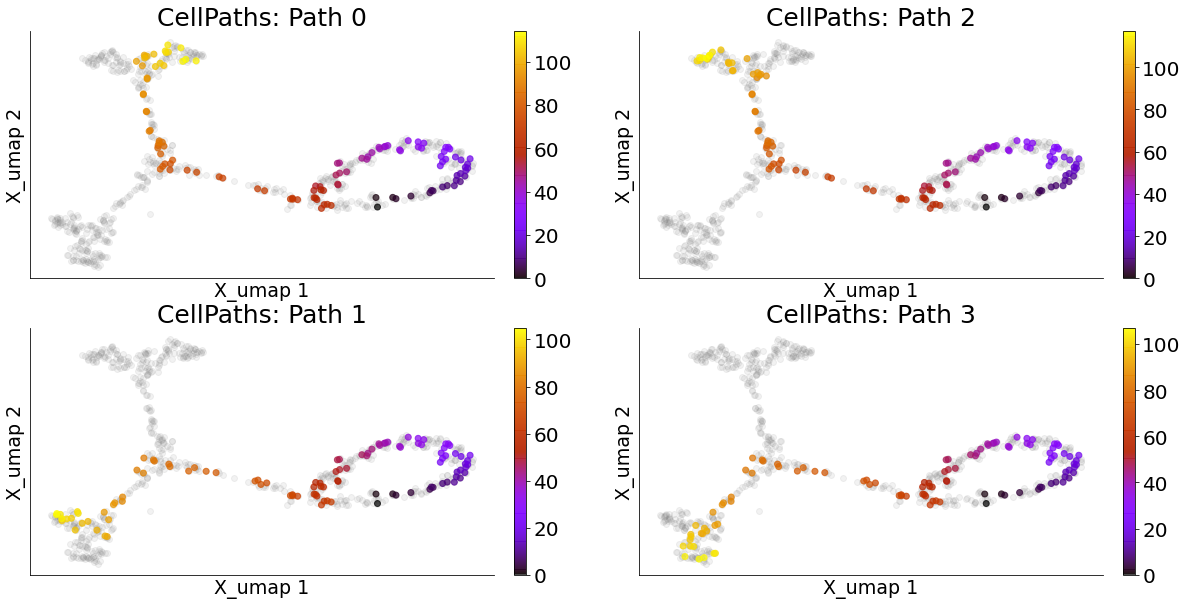

In [7]:
visual.first_order_approx_pt(cellpath_obj, basis="umap", trajs = 4, figsize=(20,10), save_as= None)

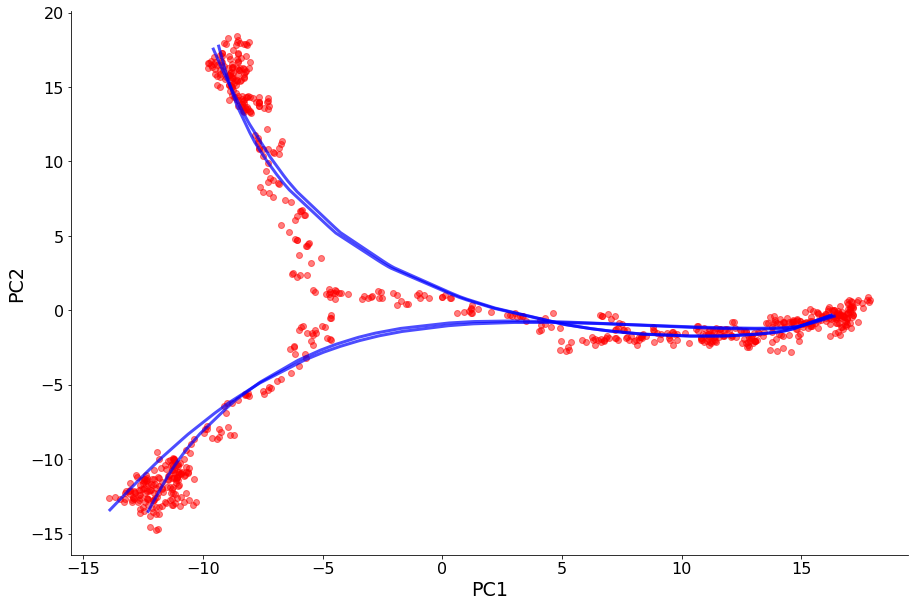

In [8]:
visual.traj_visual(cellpath_obj, cmap="tab20")

In [11]:
bmk.cellpath_kt(cellpath_obj)

{&#39;traj_0&#39;: 0.9575896262395119,
 &#39;traj_1&#39;: 0.9493261455525608,
 &#39;traj_2&#39;: 0.9585687382297553,
 &#39;traj_3&#39;: 0.9522326064382138,
 &#39;traj_4&#39;: 0.95832083958021,
 &#39;traj_5&#39;: 0.9563843236409608,
 &#39;traj_6&#39;: 0.9494505494505493,
 &#39;traj_7&#39;: 0.9568390001552556,
 &#39;traj_8&#39;: 0.9590333038608899,
 &#39;traj_9&#39;: 0.9575896262395119,
 &#39;traj_10&#39;: 0.9587385794282346,
 &#39;traj_11&#39;: 0.9581491305629236,
 &#39;traj_12&#39;: 0.95832083958021,
 &#39;traj_13&#39;: 0.9580209895052474,
 &#39;traj_14&#39;: 0.95832083958021,
 &#39;traj_15&#39;: 0.9580209895052474,
 &#39;traj_16&#39;: 0.95832083958021,
 &#39;traj_17&#39;: 0.9575896262395119,
 &#39;traj_18&#39;: 0.9549549549549547,
 &#39;traj_19&#39;: 0.9552767052767052,
 &#39;traj_20&#39;: 0.9568390001552556,
 &#39;traj_21&#39;: 0.9560682680151706,
 &#39;traj_22&#39;: 0.9575896262395119,
 &#39;traj_23&#39;: 0.9563843236409608,
 &#39;traj_24&#39;: 0.9563843236409608,
 &#39;traj_25&#39;

## latent pseudotime

In [30]:
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1.h5ad")
scv.tl.recover_dynamics(adata)
scv.tl.latent_time(adata)
y_latent = adata.obs["latent_time"].values
pred  = {}
kt = {}
non_zeros = {}
pt_true = {}

for icol, col in enumerate(cellpath_obj.pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(cellpath_obj.pseudo_order[col].values.squeeze()))[0]
    pred[col] = y_latent[non_zeros[col]]
    pt_true[col] = cellpath_obj.adata.obs["sim_time"].iloc[non_zeros[col]].values
    kt[col] = bmk.kendalltau(pred[col], pt_true[col])

recovering dynamics
    finished (0:01:52) --&gt; added 
    &#39;fit_pars&#39;, fitted parameters for splicing dynamics (adata.var)
computing terminal states
    identified 1 region of root cells and 2 regions of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)
computing latent time
    finished (0:00:00) --&gt; added 
    &#39;latent_time&#39;, shared time (adata.obs)


In [31]:
kt

{&#39;traj_0&#39;: 0.21559353317782687,
 &#39;traj_1&#39;: 0.10837527134057716,
 &#39;traj_2&#39;: 0.25659229478241913,
 &#39;traj_3&#39;: 0.1381339816436752,
 &#39;traj_4&#39;: 0.22868711682992307,
 &#39;traj_5&#39;: 0.18980640122475426,
 &#39;traj_6&#39;: 0.06429160206466016,
 &#39;traj_7&#39;: 0.2001552819161501,
 &#39;traj_8&#39;: 0.24082535265245306,
 &#39;traj_9&#39;: 0.21559353317782687,
 &#39;traj_10&#39;: 0.24229919201997113,
 &#39;traj_11&#39;: 0.24229919201997113,
 &#39;traj_12&#39;: 0.22881991560286236,
 &#39;traj_13&#39;: 0.22911981064297096,
 &#39;traj_14&#39;: 0.22911981064297096,
 &#39;traj_15&#39;: 0.2289870343601918,
 &#39;traj_16&#39;: 0.2285200205627538,
 &#39;traj_17&#39;: 0.2152883760183395,
 &#39;traj_18&#39;: 0.1745635915872658,
 &#39;traj_19&#39;: 0.17520714399864742,
 &#39;traj_20&#39;: 0.20170807696592627,
 &#39;traj_21&#39;: 0.18808282201098583,
 &#39;traj_22&#39;: 0.21695018752573472,
 &#39;traj_23&#39;: 0.18854207881859436,
 &#39;traj_24&#39;: 0.1891742400

## velocity DPT

In [28]:
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1.h5ad")
scv.tl.velocity_pseudotime(adata)
y_vdpt = adata.obs['velocity_pseudotime'].values
pred  = {}
kt = {}
non_zeros = {}
pt_true = {}

for icol, col in enumerate(cellpath_obj.pseudo_order.columns):
    non_zeros[col] = np.where(~np.isnan(cellpath_obj.pseudo_order[col].values.squeeze()))[0]
    pred[col] = y_vdpt[non_zeros[col]]
    pt_true[col] = cellpath_obj.adata.obs["sim_time"].iloc[non_zeros[col]].values
    kt[col] = bmk.kendalltau(pred[col], pt_true[col])

computing terminal states
    identified 1 region of root cells and 2 regions of end points 
    finished (0:00:00) --&gt; added
    &#39;root_cells&#39;, root cells of Markov diffusion process (adata.obs)
    &#39;end_points&#39;, end points of Markov diffusion process (adata.obs)


In [29]:
kt

{&#39;traj_0&#39;: 0.817758794049183,
 &#39;traj_1&#39;: 0.7545372866127584,
 &#39;traj_2&#39;: 0.8208620086729883,
 &#39;traj_3&#39;: 0.7691242644513672,
 &#39;traj_4&#39;: 0.8199130396569145,
 &#39;traj_5&#39;: 0.8116308470290771,
 &#39;traj_6&#39;: 0.7846153846153845,
 &#39;traj_7&#39;: 0.8145330356041935,
 &#39;traj_8&#39;: 0.8242576103727318,
 &#39;traj_9&#39;: 0.8171485262924298,
 &#39;traj_10&#39;: 0.8242576103727318,
 &#39;traj_11&#39;: 0.8239628642220532,
 &#39;traj_12&#39;: 0.8212009918870945,
 &#39;traj_13&#39;: 0.8209011193320873,
 &#39;traj_14&#39;: 0.8209011193320873,
 &#39;traj_15&#39;: 0.8212009918870945,
 &#39;traj_16&#39;: 0.8212009918870945,
 &#39;traj_17&#39;: 0.8180639279275596,
 &#39;traj_18&#39;: 0.8082368082368081,
 &#39;traj_19&#39;: 0.8075933075933075,
 &#39;traj_20&#39;: 0.8154646402960779,
 &#39;traj_21&#39;: 0.8121691056569627,
 &#39;traj_22&#39;: 0.8181540808543099,
 &#39;traj_23&#39;: 0.8113147914032869,
 &#39;traj_24&#39;: 0.8116308470290771,
 &#39;traj_

## Slingshot

In [12]:
from sklearn.cluster import KMeans
import scprep
import pandas as pd

In [14]:
adata = anndata.read_h5ad("./sim_data/Symsim/cycle_tree_rand1_clust.h5ad")
X_pca = adata.obsm['X_umap']

In [15]:
n_clusters = 10
init = "k-means++"
n_init = 10
max_iter = 300
tol = 0.0001
kmeans = KMeans(n_clusters, init, n_init, max_iter, tol)
groups = kmeans.fit_predict(X_pca)
meta_data = adata.obs
meta_data['groups'] = groups

Text(0.5, 1.0, &#39;slingshot clusters&#39;)

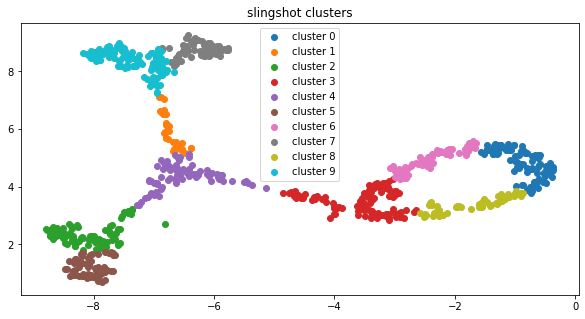

In [16]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()
c_range = [eval(x) if isinstance(x, str) else x for x in adata.obs['sim_time']]
clusters = int(np.max(groups)+1)
for i in range(clusters):
    sub_cells = np.where(groups == i)[0]
    progression = ax.scatter(X_pca[sub_cells,0], X_pca[sub_cells,1], cmap = plt.get_cmap('Pastel1'))
    # progression = ax.scatter(X_umap[sub_cells,0], X_umap[sub_cells,1], cmap = plt.get_cmap('Pastel1'))

ax.legend(['cluster '+ str(i) for i in range(clusters)])
ax.set_title("slingshot clusters")
# fig.savefig("./syn_results/dataset1/slingshot_clust.pdf")

In [18]:
X_pca_df = pd.DataFrame(index=[str(x) for x in range(X_pca.shape[0])], columns= np.arange(2), data = X_pca[:,0:2])
# scprep.run.install_bioconductor('slingshot')
results = scprep.run.Slingshot(X_pca_df, meta_data['groups'], start_cluster = 3)

R[write to console]: Using full covariance matrix


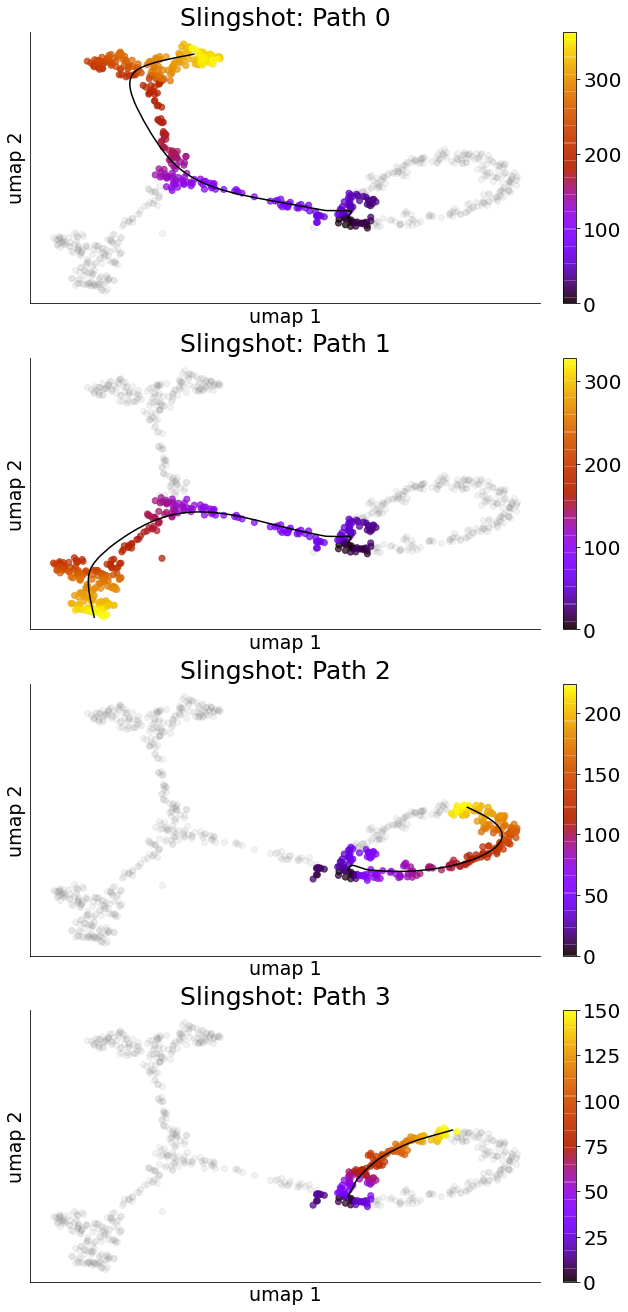

In [20]:
kt_slingshot = visual.slingshot_visual(adata, results, figsize=(10,23), save_as = None)

In [26]:
kts = {"CellPaths": kt, "slingshot": kt_slingshot, "vdpt": kt_vdpt}
with open("./sim_results/Symsim/cycle_tree/quantity/rand2.json", "w") as fp:
    json.dump(kts, fp)

In [30]:
with open("./sim_results/Symsim/cycle_tree/quantity/rand1.json", "r") as fp:
    kts_1 = json.load(fp)
with open("./sim_results/Symsim/cycle_tree/quantity/rand2.json", "r") as fp:
    kts_2 = json.load(fp)

In [35]:
kts["CellPaths"] = [x for x in kts_1["CellPaths"].values()]
kts["CellPaths"].extend([x for x in kts_2["CellPaths"].values()])

kts["slingshot"] = [x for x in kts_1["slingshot"].values()]
kts["slingshot"].extend([x for x in kts_2["slingshot"].values()])

kts["vdpt"] = [x for x in kts_1["vdpt"].values()]
kts["vdpt"].extend([x for x in kts_2["vdpt"].values()])


In [21]:
kts_array = [kts["CellPaths"], kts["slingshot"], kts["vdpt"]]

NameError: name &#39;kts&#39; is not defined

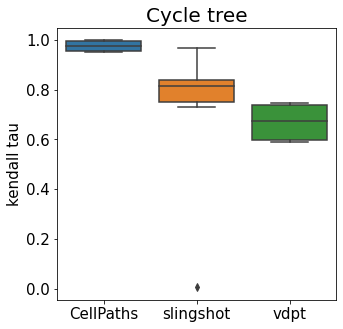

In [74]:
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot()
sns.boxplot(data = kts_array, ax = ax)#, x = ["CellPaths", "slingshot", "vdpt"])
ax.set_xticklabels(["CellPaths", "slingshot", "vdpt"],fontsize = 15)
ax.set_ylabel("kendall tau", fontsize = 15)
plt.yticks(fontsize = 15)
ax.set_title("Cycle tree", fontsize = 20)
fig.savefig("./sim_results/Symsim/cycle_tree/quantity/boxplot.pdf", bbox_inches = "tight")

# Benchmark

In [14]:
bmk_belongings = bmk.purity_count(adata, paths, greedy_paths, trajs = trajs)
bmk_belongings      

,ori_traj_1,ori_traj_2,ori_traj_3,ori_traj_4,ori_traj_5
reconst_1,50,39,44,88,42
reconst_2,49,25,71,23,29
reconst_3,26,43,27,30,63
reconst_4,55,35,44,95,42
reconst_5,52,36,44,93,42
reconst_6,50,39,44,90,42


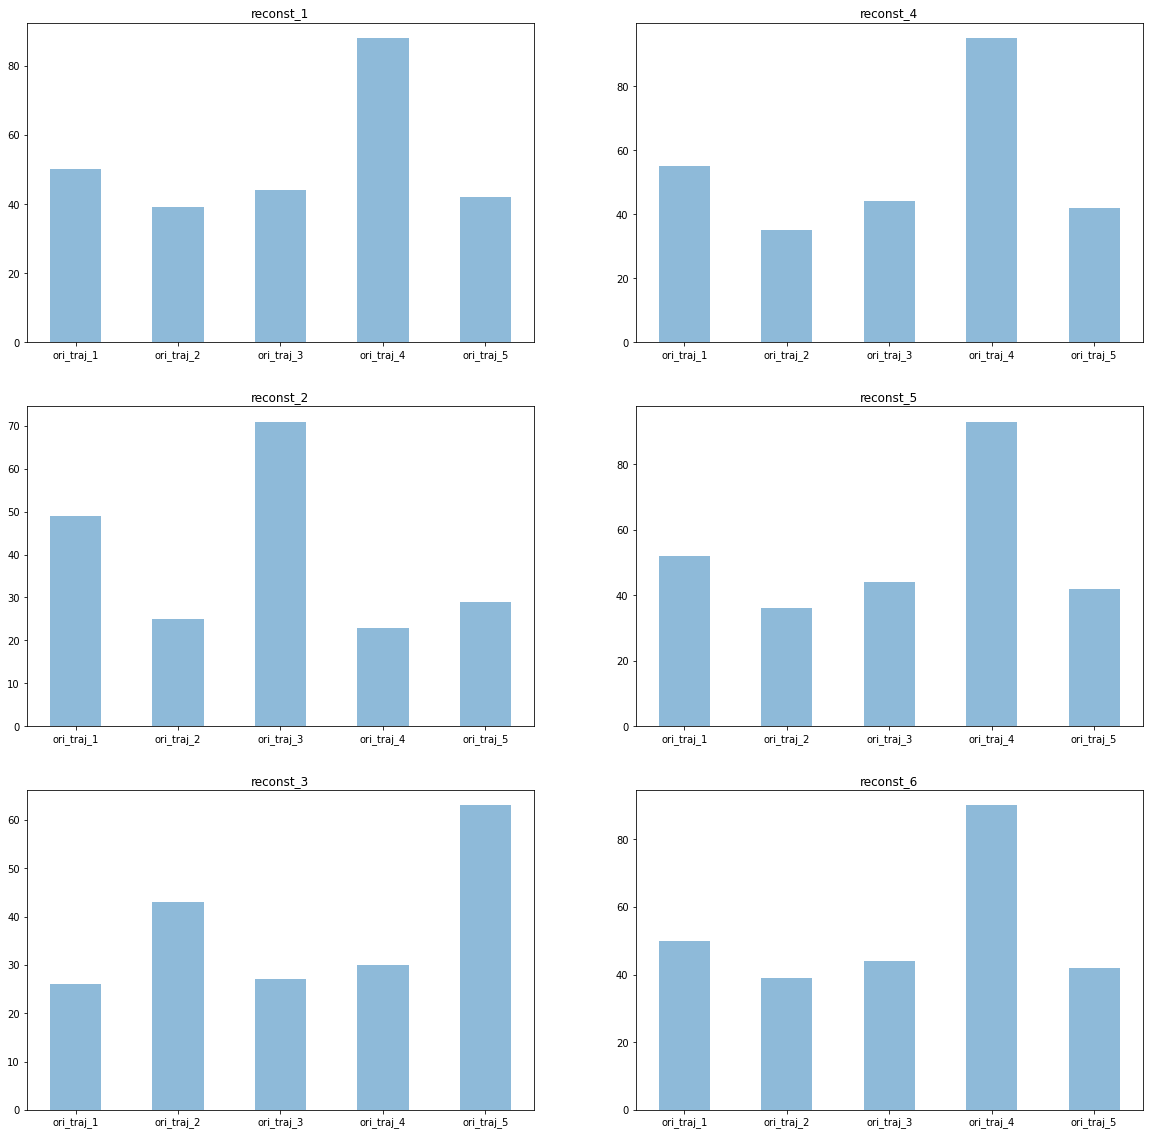

In [15]:
visual.purity_bar(bmk_belongings, trajs = trajs)